Helpful example

https://www.kaggle.com/tianxinl0106/content-based-anime-recommender

https://www.kaggle.com/tanetboss/user-clustering-for-anime-recommendation

In [76]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pygtrie
from pandas.io.json import json_normalize
#from wordcloud import WordCloud, STOPWORDS
# Loading data
import datetime
import re
from sklearn.feature_extraction.text import CountVectorizer
import itertools
import collections
from sklearn.metrics import jaccard_similarity_score # Jaccard Similarity
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from scipy import sparse
import pickle

plt.style.use('fivethirtyeight')

In [2]:
rating = pd.read_csv("rating.csv")
anime = pd.read_csv('anime.csv')
print (rating.shape, anime.shape)

(7813737, 3) (12294, 7)


In [3]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


### Data analysis for anime:

In [5]:
anime['genre'][:10]

0                 Drama, Romance, School, Supernatural
1    Action, Adventure, Drama, Fantasy, Magic, Mili...
2    Action, Comedy, Historical, Parody, Samurai, S...
3                                     Sci-Fi, Thriller
4    Action, Comedy, Historical, Parody, Samurai, S...
5               Comedy, Drama, School, Shounen, Sports
6              Action, Adventure, Shounen, Super Power
7                       Drama, Military, Sci-Fi, Space
8    Action, Comedy, Historical, Parody, Samurai, S...
9    Action, Comedy, Historical, Parody, Samurai, S...
Name: genre, dtype: object

In [6]:
# how many empty genres are there
anime['genre'].isnull().sum()

62

In [7]:
# filling 'empty' data
anime['genre'] = anime['genre'].fillna('None')
# split genre into a list
anime['genre'] = anime['genre'].apply(lambda x: x.split(', '))
anime["name"] = anime["name"].map(lambda name:re.sub('[^A-Za-z0-9]+', " ", name))

In [8]:
# number of average episodes among anime shows
sum_ep = np.sum(int(x) if x != 'Unknown' else 0 for x in anime['episodes'])
ep_avg = int(sum_ep / len(anime['episodes']))
anime['episodes'] = anime['episodes'].apply(lambda x: ep_avg if x == 'Unknown' else int(x))
anime['rating'] = anime['rating'].fillna(ep_avg)

In [9]:
# flatten the list
genre_set = set(itertools.chain(*anime['genre'].values.tolist()))

genre_iter = itertools.chain(*anime['genre'].values.tolist())
genre_counter = collections.Counter(genre_iter)

In [10]:
genredf = pd.DataFrame.from_dict(genre_counter, orient='index').rename(columns={'index':'genre', 0:'count'})
genredf.sort_values('count', ascending=True, inplace=True)
genredf.head()

,count
Yaoi,39
Yuri,42
Josei,54
Shoujo Ai,55
None,62


/Users/tuvttran/anaconda3/envs/ML/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


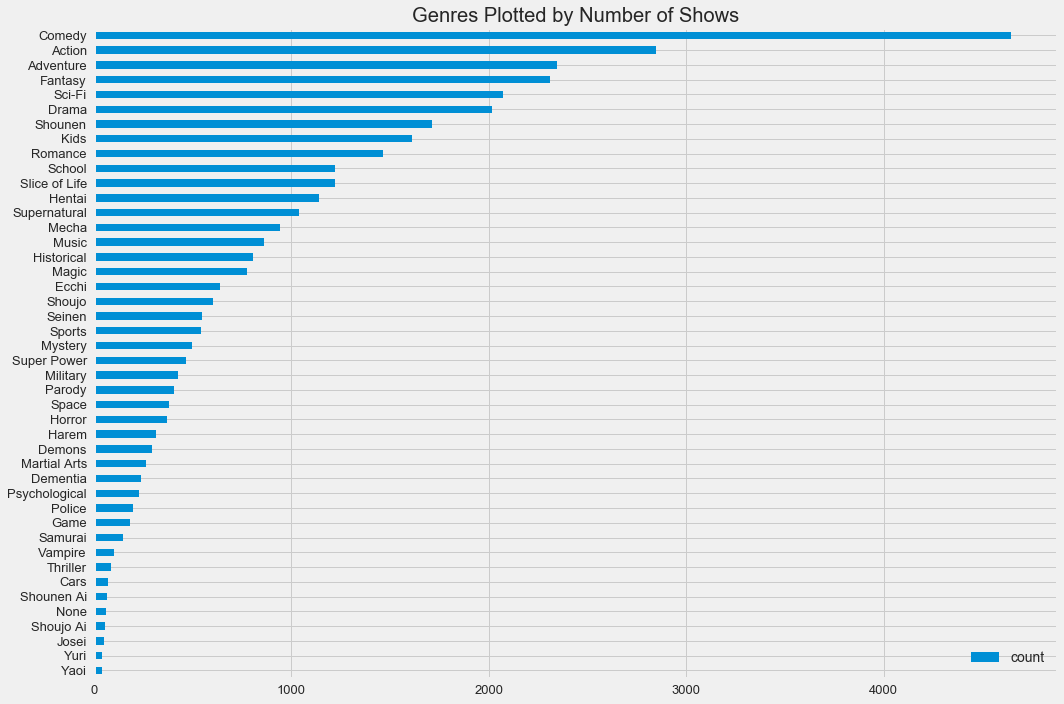

In [11]:
genredf.plot(kind='barh', figsize=(15, 10), title="Genres Plotted by Number of Shows")
plt.legend(fontsize=14)
plt.xticks(fontsize=13);
plt.yticks(fontsize=13);

In [12]:
# change genre into one hot encoded
anime_extra = anime['genre'].str.join(sep='*').str.get_dummies(sep='*')
print(len(anime_extra))
anime_extra.head()

12294


,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/Users/tuvttran/anaconda3/envs/ML/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


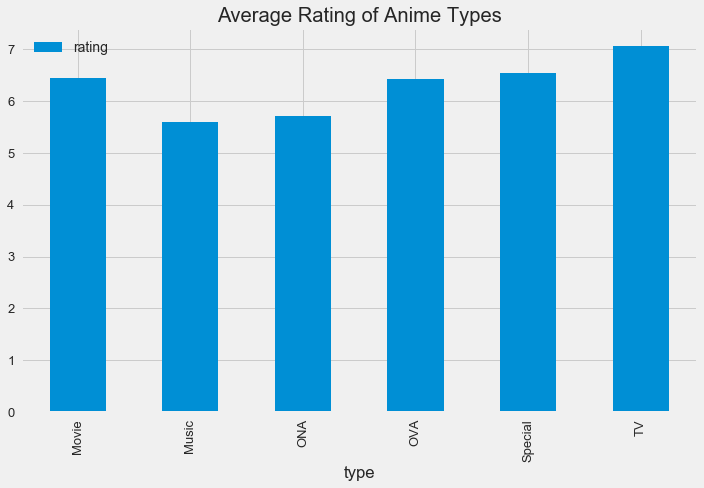

In [13]:
# average score of each type
anime.pivot_table(index='type', values=['rating'], aggfunc=np.mean).plot(
    kind='bar', figsize=(10, 7), title='Average Rating of Anime Types')
plt.legend(fontsize=14)
plt.xticks(fontsize=13);
plt.yticks(fontsize=13);

In [14]:
# shows with most episodes
anime.sort_values(by='episodes', ascending=False).head()

,anime_id,name,genre,type,episodes,rating,members
6296,12393,Oyako Club,"[Comedy, Slice of Life]",TV,1818,6.18,160
929,2471,Doraemon 1979,"[Adventure, Comedy, Fantasy, Kids, Sci-Fi, Sho...",TV,1787,7.76,14233
9243,23349,Kirin Monoshiri Yakata,[Kids],TV,1565,5.56,116
5360,6277,Manga Nippon Mukashibanashi 1976,"[Fantasy, Historical]",TV,1471,6.48,406
6580,8213,Hoka Hoka Kazoku,[Comedy],TV,1428,6.05,194


/Users/tuvttran/anaconda3/envs/ML/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


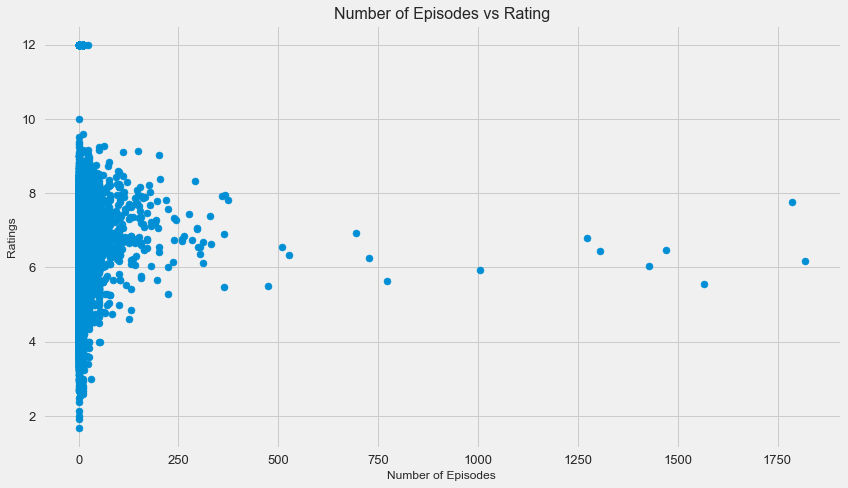

In [15]:
plt.figure(figsize=(12, 7))
plt.title('Number of Episodes vs Rating', fontsize=16)
plt.scatter(anime['episodes'], anime['rating'])
plt.xlabel('Number of Episodes', fontsize=12)
plt.ylabel('Ratings', fontsize=12)
plt.xticks(fontsize=13);
plt.yticks(fontsize=13);

In [16]:
anime.iloc[anime['rating'].argmax()]

anime_id                       34502
name                 Inazma Delivery
genre       [Action, Comedy, Sci-Fi]
type                              TV
episodes                          10
rating                            12
members                           32
Name: 8968, dtype: object

/Users/tuvttran/anaconda3/envs/ML/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/Users/tuvttran/anaconda3/envs/ML/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


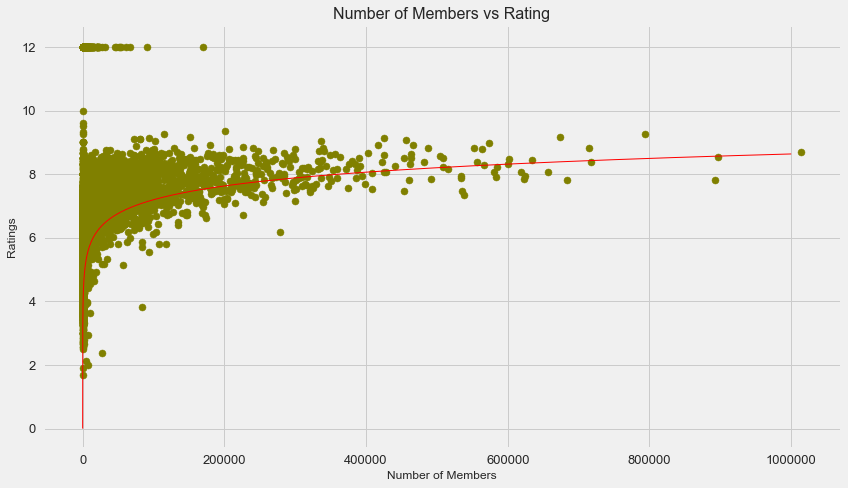

In [17]:
plt.figure(figsize=(12, 7))
plt.title('Number of Members vs Rating', fontsize=16)
plt.plot(np.arange(0, 1000000), 1/1.6*np.log(np.arange(0,1000000)), color='red', linewidth=1)
plt.scatter(anime['members'], anime['rating'], color='olive')
plt.xlabel('Number of Members', fontsize=12)
plt.ylabel('Ratings', fontsize=12)
plt.xticks(fontsize=13);
plt.yticks(fontsize=13);

In [18]:
anime['rating'].isnull().sum()

0

/Users/tuvttran/anaconda3/envs/ML/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


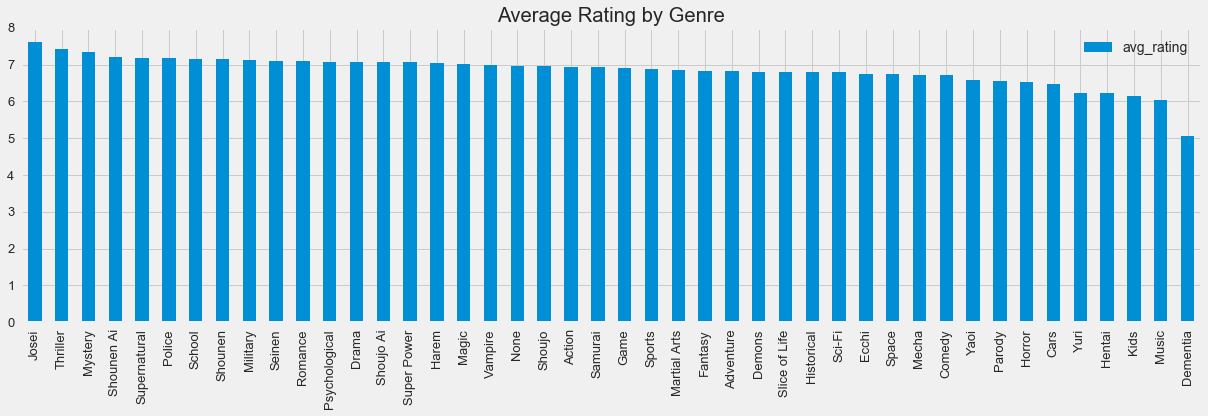

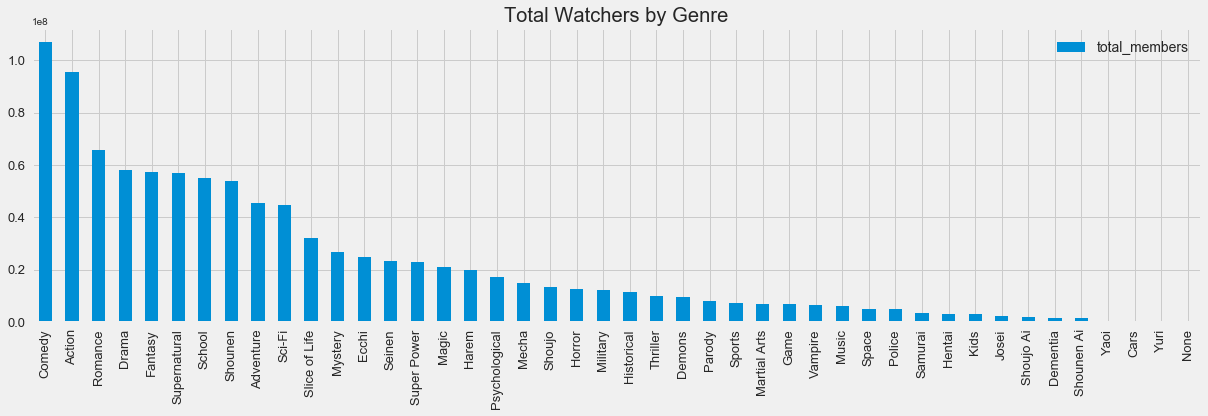

In [19]:
# average score of each genre
avg_genre_dict = {}
total_genre_watcher = {}
for genre in genre_set:
    sum_rating = 0
    total_watchers = 0
    for i, x in enumerate(anime_extra[genre]):
        if x == 1:
            sum_rating += anime['rating'][i]
            total_watchers += anime['members'][i]
    avg_genre_dict[genre] = sum_rating / anime_extra[genre].sum()
    total_genre_watcher[genre] = total_watchers
pd.DataFrame\
    .from_dict(avg_genre_dict, orient='index')\
    .rename(columns={0: 'avg_rating'}).sort_values(by='avg_rating', ascending=False)\
    .plot(kind='bar', figsize=(17, 6), title="Average Rating by Genre")
plt.legend(fontsize=14)
plt.xticks(fontsize=13);
plt.yticks(fontsize=13);

pd.DataFrame\
    .from_dict(total_genre_watcher, orient='index')\
    .rename(columns={0: 'total_members'}).sort_values(by='total_members', ascending=False)\
    .plot(kind='bar', figsize=(17, 6), title="Total Watchers by Genre")
plt.legend(fontsize=14)
plt.xticks(fontsize=13);
plt.yticks(fontsize=13);

In [20]:
def pca_anime(data, title, color):
    anime_full = pd.concat(data, axis=1)

    # dimensionality using PCA
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(anime_full)

    print(pca_data)

    plt.figure(figsize=(13, 7))
    plt.title(title, fontsize=16)
    plt.scatter(pca_data[:, 0], pca_data[:, 1], color=color)
    plt.xticks(fontsize=13);
    plt.yticks(fontsize=13);

[[  1.82558660e+05  -1.99703716e+01]
 [  7.75593663e+05   1.50976299e+01]
 [  9.61906629e+04   3.41035068e+01]
 ..., 
 [ -1.78523393e+04  -7.53549222e+00]
 [ -1.78963394e+04  -1.05332655e+01]
 [ -1.79293394e+04  -1.05308897e+01]]


/Users/tuvttran/anaconda3/envs/ML/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


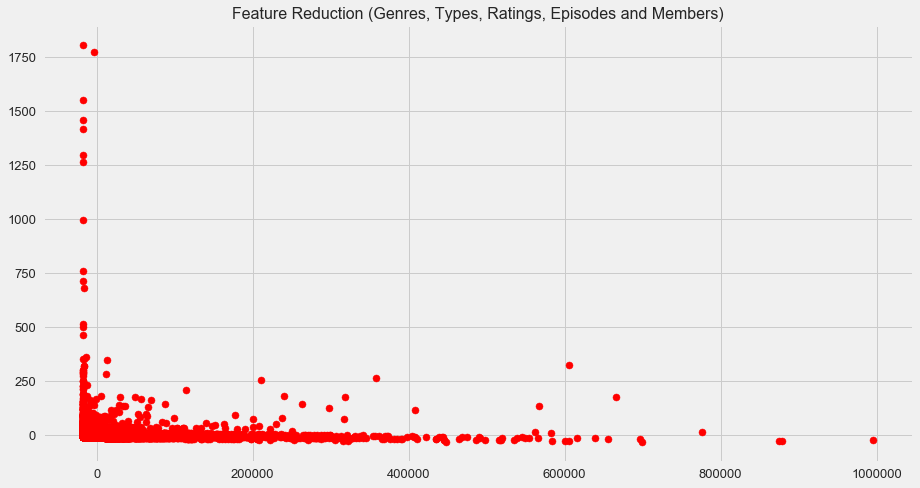

In [21]:
pca_anime([
    anime_extra,
    pd.get_dummies(anime[['type']]),
    anime[['episodes', 'rating', 'members']]
], "Feature Reduction (Genres, Types, Ratings, Episodes and Members)", 'red')

[[-11.36904428   2.83249006]
 [ 51.63557634   2.79946171]
 [ 38.63622088   2.73983772]
 ..., 
 [ -8.37741582  -1.79404446]
 [-11.37721299  -1.68931043]
 [-11.37613797  -1.20173971]]


/Users/tuvttran/anaconda3/envs/ML/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


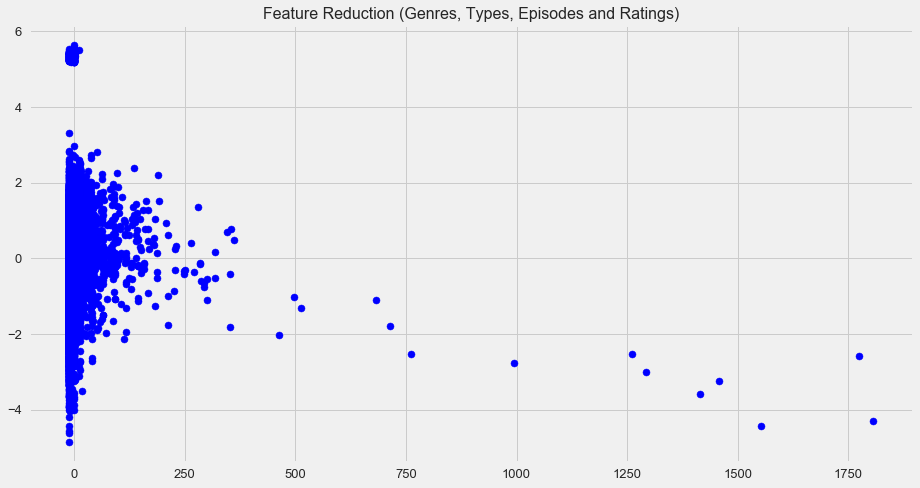

In [22]:
pca_anime([
    anime_extra,
    pd.get_dummies(anime[['type']]),
    anime[['episodes', 'rating']]
], "Feature Reduction (Genres, Types, Episodes and Ratings)", 'blue')

[[-11.37397234   0.08158123]
 [ 51.63093888  -0.7013795 ]
 [ 38.631581    -0.97265064]
 ..., 
 [ -8.3744443    1.15098215]
 [-11.37442194   1.14225234]
 [-11.37419091   0.57762762]]


/Users/tuvttran/anaconda3/envs/ML/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


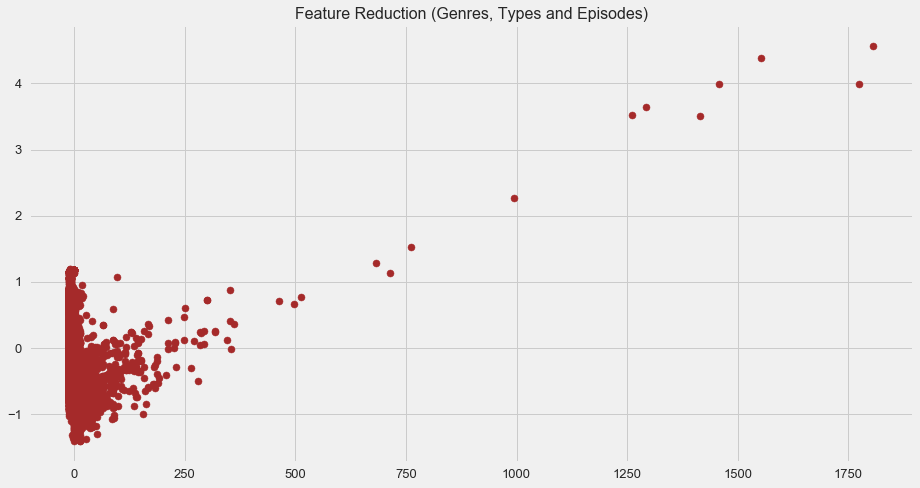

In [23]:
pca_anime([
    anime_extra,
    pd.get_dummies(anime[['type']]),
    anime[['episodes']]
], "Feature Reduction (Genres, Types and Episodes)", 'brown')

[[-0.17103074 -0.02375175]
 [ 0.86578502  1.26044416]
 [ 1.10184133  0.43906628]
 ..., 
 [-1.12784238 -0.22470707]
 [-1.12784238 -0.22470707]
 [-0.64109345  0.03887228]]


/Users/tuvttran/anaconda3/envs/ML/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


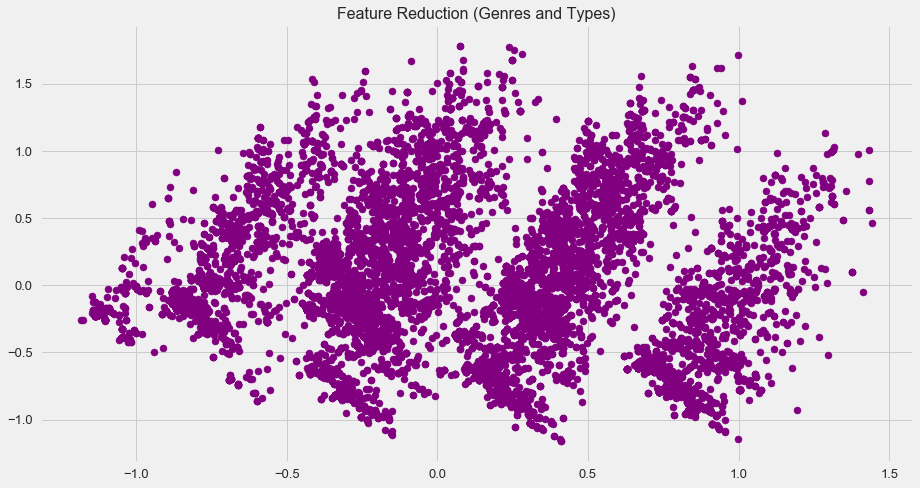

In [24]:
pca_anime([
    anime_extra,
    pd.get_dummies(anime[['type']]),
], "Feature Reduction (Genres and Types)", 'purple')

[[-0.22694803 -0.39177925]
 [ 1.26773764  0.50303461]
 [ 0.53058422  0.97761989]
 ..., 
 [-0.15103315 -0.70528819]
 [-0.15103315 -0.70528819]
 [-0.15103315 -0.70528819]]


/Users/tuvttran/anaconda3/envs/ML/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


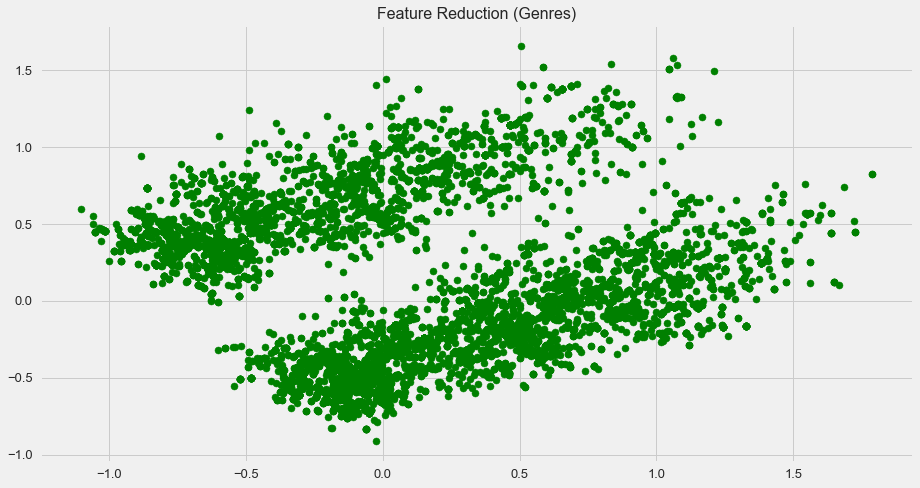

In [25]:
pca_anime([
    anime_extra,
], "Feature Reduction (Genres)", 'green')

### Content-based recommendation:

In [26]:
def get_partial_names(name, top, df):
    """
        Return a list of shows that contain 'name'
    """
    result = df[df['name'].str.contains(name, case=False)][['anime_id', 'name']][:top]
    # if we have an exact match
    try:
        first_match = df[df["name"]==name].index.tolist()[0]
    except:
        # if there is no exact match
        first_match = -1
    return result, first_match

# get 10 anime that has the name Naruto
matches, eid = get_partial_names('Naruto', 10, anime)

print(matches)
print()
print(eid)

      anime_id                                               name
486      28755                            Boruto Naruto the Movie
615       1735                                  Naruto Shippuuden
719      16870                          The Last Naruto the Movie
784      13667            Naruto Shippuuden Movie 6 Road to Ninja
841         20                                             Naruto
1103     32365  Boruto Naruto the Movie Naruto ga Hokage ni Na...
1237     10589             Naruto Shippuuden Movie 5 Blood Prison
1343     10075                                        Naruto x UT
1472      8246           Naruto Shippuuden Movie 4 The Lost Tower
1573      6325  Naruto Shippuuden Movie 3 Hi no Ishi wo Tsugu ...

841


In [27]:
anime_full = pd.concat([
#     anime[['episodes', 'rating', 'members']],
    anime_extra,
#     pd.get_dummies(anime[['type']])
], axis=1)

anime_full.head(10)

,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# build a KNN model
knn = NearestNeighbors(n_neighbors=7, algorithm='ball_tree').fit(anime_full)
distances, indices = knn.kneighbors(anime_full)

In [29]:
distances[841]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [30]:
def get_similar_anime(df, name=None, id=None):
    """
        This function acts as a content-based recommendation engine
        that gets similar anime based on its name or its id
        
        If the name matches then we return a list of similar anime based on the
        exact id match or based on the first in shows that kinda have the same name
    """
    if name:
        matches, exact_id = get_partial_names(name, 7, df)
        if exact_id != -1:
            return list(indices[exact_id][1:])
        elif len(matches) > 0:
            return list(indices[matches.index[0]][1:])
        else:
            return []
    elif id:
        return list(indices[id])

In [31]:
# anime similar to Re Zero
anime.iloc[get_similar_anime(anime, 'Re Zero')]

,anime_id,name,genre,type,episodes,rating,members
54,31240,Re Zero kara Hajimeru Isekai Seikatsu,"[Drama, Fantasy, Psychological, Thriller]",TV,25,8.64,355839
6569,7257,Shijin no Shougai,"[Drama, Fantasy, Psychological]",Movie,1,6.06,541
3109,21027,Saibi,"[Drama, Psychological, Thriller]",Movie,1,7.08,1747
1238,3420,Shigofumi,"[Drama, Fantasy, Psychological, Supernatural, ...",TV,12,7.62,54000
217,11977,Mahou Shoujo Madoka Magica Movie 1 Hajimari no...,"[Drama, Magic, Psychological, Thriller]",Movie,1,8.31,88164
102,11981,Mahou Shoujo Madoka Magica Movie 3 Hangyaku no...,"[Drama, Magic, Psychological, Thriller]",Movie,1,8.50,135735


In [32]:
# anime similar to Naruto
anime.iloc[get_similar_anime(anime, 'Naruto')]

,anime_id,name,genre,type,episodes,rating,members
1103,32365,Boruto Naruto the Movie Naruto ga Hokage ni Na...,"[Action, Comedy, Martial Arts, Shounen, Super ...",Special,1,7.68,16868
1573,6325,Naruto Shippuuden Movie 3 Hi no Ishi wo Tsugu ...,"[Action, Comedy, Martial Arts, Shounen, Super ...",Movie,1,7.50,83515
2458,19511,Naruto Shippuuden Sunny Side Battle,"[Action, Comedy, Martial Arts, Shounen, Super ...",Special,1,7.26,13014
1472,8246,Naruto Shippuuden Movie 4 The Lost Tower,"[Action, Comedy, Martial Arts, Shounen, Super ...",Movie,1,7.53,84527
1343,10075,Naruto x UT,"[Action, Comedy, Martial Arts, Shounen, Super ...",OVA,1,7.58,23465
841,20,Naruto,"[Action, Comedy, Martial Arts, Shounen, Super ...",TV,220,7.81,683297


In [33]:
anime.iloc[get_similar_anime(anime, None, 206)]

,anime_id,name,genre,type,episodes,rating,members
206,813,Dragon Ball Z,"[Action, Adventure, Comedy, Fantasy, Martial A...",TV,291,8.32,375662
4275,6714,Dragon Ball Z Atsumare Gokuu World,"[Action, Adventure, Comedy, Fantasy, Martial A...",OVA,1,6.76,10044
1409,25389,Dragon Ball Z Movie 15 Fukkatsu no F,"[Action, Adventure, Comedy, Fantasy, Martial A...",Movie,1,7.55,41051
5999,904,Dragon Ball Z Movie 11 Super Senshi Gekiha Kat...,"[Action, Adventure, Comedy, Fantasy, Martial A...",Movie,1,6.28,49949
3203,22695,Dragon Ball Z Summer Vacation Special,"[Action, Adventure, Comedy, Fantasy, Martial A...",Special,1,7.05,4251
588,6033,Dragon Ball Kai,"[Action, Adventure, Comedy, Fantasy, Martial A...",TV,97,7.95,116832
515,22777,Dragon Ball Kai 2014,"[Action, Adventure, Comedy, Fantasy, Martial A...",TV,61,8.01,42666


In [34]:
anime.iloc[get_similar_anime(anime, 'kimi no na wa')]

,anime_id,name,genre,type,episodes,rating,members
6394,546,Wind A Breath of Heart TV,"[Drama, Romance, School, Supernatural]",TV,13,6.14,7778
0,32281,Kimi no Na wa,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630
1436,8481,quot Bungaku Shoujo quot Memoire,"[Drama, Romance, School]",OVA,3,7.54,18013
504,6351,Clannad After Story Mou Hitotsu no Sekai Kyou hen,"[Drama, Romance, School]",Special,1,8.02,138364
1435,2129,True Tears,"[Drama, Romance, School]",TV,13,7.55,118644
208,28725,Kokoro ga Sakebitagatterunda,"[Drama, Romance, School]",Movie,1,8.32,59652


### Collaborative recommendation:

In [37]:
# create a matrix of user interactions with each anime show
anime_user = pd.merge(anime, rating, on=['anime_id', 'anime_id'])\
            .rename(columns={'rating_x': 'avg_rating', 'rating_y': 'indi_rating'})
anime_user.head(10)

,anime_id,name,genre,type,episodes,avg_rating,members,user_id,indi_rating
0,32281,Kimi no Na wa,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,271,10
4,32281,Kimi no Na wa,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,278,-1
5,32281,Kimi no Na wa,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,322,10
6,32281,Kimi no Na wa,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,398,10
7,32281,Kimi no Na wa,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,462,8
8,32281,Kimi no Na wa,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,490,10
9,32281,Kimi no Na wa,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,548,10


In [38]:
name_to_index = {}
id_to_index = {}
# map unique shows that are rated by user to an index
for i, show in enumerate(anime_user['name'].unique()):
    name_to_index[show] = i
# map user id to index
for i, id in enumerate(anime_user['user_id'].unique()):
    id_to_index[id] = i

In [39]:
for row in anime_user[:5].index:
    print(anime_user.ix[row]['user_id'])
    print(anime_user.ix[row]['name'])
    print(anime_user.ix[row]['indi_rating'])

99
Kimi no Na wa 
5
152
Kimi no Na wa 
10
244
Kimi no Na wa 
10
271
Kimi no Na wa 
10
278
Kimi no Na wa 
-1


In [55]:
collab_mat = np.zeros((len(id_to_index), len(name_to_index))).astype('int32')
collab_mat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [58]:
for row in anime_user.index:
    data = anime_user.ix[row]
    # assign rating to show with respect to user
    collab_mat[
        id_to_index[data['user_id']],
        name_to_index[data['name']]
    ] = data['indi_rating']

In [68]:
# create a sparse matrix to save space
collab_mat = sparse.coo_matrix(collab_mat)

In [72]:
# anime names from sparse matrix
anime_names = anime_user['name'].unique()
user_ids = anime_user['user_id'].unique()
pickle.dump(anime_names, open('anime_names.pkl', 'wb'))
pickle.dump(user_ids, open('user_ids.pkl', 'wb'))
pickle.dump(collab_mat, open('collab_mat.pkl', 'wb'))
print(anime_names)
print(user_ids)

['Kimi no Na wa ' 'Fullmetal Alchemist Brotherhood' 'Gintama ' ...,
 'Violence Gekiga David no Hoshi'
 'Violence Gekiga Shin David no Hoshi Inma Densetsu'
 'Yasuji no Pornorama Yacchimae ']
[   99   152   244 ..., 40965 55932 64425]


In [73]:
# create recommendation model
model = LightFM(loss='warp')
%time model.fit(collab_mat_compressed, epochs=30, num_threads=20)

CPU times: user 4min 41s, sys: 2.24 s, total: 4min 43s
Wall time: 4min 45s


In [74]:
# save trained model to file
pickle.dump(model, open('lightfm_model.pkl', 'wb'))

In [81]:
print("Train precision: %.2f" % precision_at_k(model, collab_mat, k=5).mean())

Train precision: 0.61


In [93]:
# get list of anime shows user 0 like
anime_names[collab_mat.tocsr()[0].indices[:5]]

array(['Kimi no Na wa ', 'Fullmetal Alchemist Brotherhood', 'Steins Gate',
       'Clannad After Story', 'Code Geass Hangyaku no Lelouch R2'], dtype=object)

In [145]:
# sample recommendation
# entering a list of ids
def sample_recommendation(model, data, user_ids, name_list, id_dict):
    n_users, n_items = data.shape
    for user_id in user_ids:
        uid = id_dict[user_id]
        # get the list of anime shows user has liked
        known_positives = name_list[collab_mat.tocsr()[uid].indices]
        scores = model.predict(uid, np.arange(n_items))
        top_anime = name_list[np.argsort(-scores)]
        print("User %s" % uid)
        print("\tUser has liked:")

        for item in known_positives[:5]:
            print("\t\t%s" % item)

        print()

        print("\tRecommended:")
        for item in top_anime[:5]:
            print("\t\t%s" % item)

In [146]:
sample_recommendation(model, collab_mat, [3, 23], anime_names, id_to_index)

User 2199
	User has liked:
		Fullmetal Alchemist Brotherhood
		Haikyuu Second Season
		Sen to Chihiro no Kamikakushi
		One Punch Man
		Death Note

	Recommended:
		Shingeki no Kyojin
		Sword Art Online
		Tokyo Ghoul
		Fullmetal Alchemist Brotherhood
		Digimon Adventure
User 53185
	User has liked:
		Cowboy Bebop
		Great Teacher Onizuka
		Yuu Yuu Hakusho
		Rurouni Kenshin Meiji Kenkaku Romantan
		Cowboy Bebop Tengoku no Tobira

	Recommended:
		Dragon Ball Z
		Dragon Ball GT
		Dragon Ball
		Rosario to Vampire
		Digimon Adventure


The question becomes what if we have a new user and we don't want to create a new collaborative matrix from scratch?

In [132]:
# suppose we have a new user who rates Naruto as 8
# and No Game No Life as 7
# the idea is we create a new vector of this user
# based on the dictionary of names to index
# and calculate the most similar user to this using KNN

def create_new_user_vect(name_dict, rating_dict):
    """
        This function takes a dictionary of the following
        format: { 'Naruto': 8, 'No Game No Life': 7 }
        and create a vector of size 1 x n_shows
    """
    new_vect = np.zeros((1, len(name_dict)))
    for show in rating_dict:
        new_vect[0, name_dict[show]] = rating_dict[show]
    return new_vect

In [150]:
new_user = create_new_user_vect(name_to_index, {'Naruto': 8, 'No Game No Life': 7})

# KNN model for getting most similar users from collaborative matrix
knn_collab = NearestNeighbors(n_neighbors=5, algorithm='brute', metric='euclidean').fit(collab_mat)

In [152]:
# the most similar user to this new user
most_similar_user = knn_collab.kneighbors(new_user, n_neighbors=1, return_distance=False)[0][0]
print("The most similar user to this new user likes:")
# now we recommend some shows for this user
sample_recommendation(model, collab_mat, [most_similar_user], anime_names, id_to_index)

The most similar user to this new user likes:
User 24890
	User has liked:
		Fullmetal Alchemist Brotherhood
		Hunter x Hunter 2011 
		Code Geass Hangyaku no Lelouch R2
		Code Geass Hangyaku no Lelouch
		One Punch Man

	Recommended:
		Tokyo Ghoul
		Kuroshitsuji
		Ao no Exorcist
		Shingeki no Kyojin
		Kuroshitsuji II


In [159]:
# now we understand, so make it a function
def recommend_new_user(
    rating_dict,
    data=collab_mat,
    knn_model=knn_collab,
    name_dict=name_to_index,
    name_list=anime_names,
    id_dict=id_to_index
):
    x = create_new_user_vect(name_dict, rating_dict)
    most_similar_user_id = knn_model.kneighbors(
        x, n_neighbors=1, return_distance=False)[0][0]
    uid = id_dict[most_similar_user_id]

    _, n_items = data.shape
    
    scores = model.predict(uid, np.arange(n_items))
    top_anime = name_list[np.argsort(-scores)]

    print("Recommended:")
    for item in top_anime[:5]:
        print("\t%s" % item)

In [165]:
recommend_new_user({
    'Steins Gate': 10,
    'Naruto': 10,
})

Recommended:
	Sen to Chihiro no Kamikakushi
	Shingeki no Kyojin
	Howl no Ugoku Shiro
	Tonari no Totoro
	Death Note
